# Feature Selection

Authors: Brian R. Mullen, Sero Toriano Parel, Revati Jadhav, Carrie Clark, Philip Nelson

Date: 2025-10-21

Python notebook re: feature elimination decisions, logs results in a table

Main output(s):
- feature_selection.csv: feature importance log, a tabular record of the ranking of all features by importance score (as per [02_EDA_feature_selection_and_engineering](https://docs.google.com/document/d/1Kl0Oz5YV63c0b6lbUHhTlcTJ7h4KpRAAGrQZfKX6Zyw/edit?usp=sharing))

Other output(s):
- feature_importance_ranking.csv: contains all 160 features ranked by Random Forest importance scores, created when training random forest
- tsne_feature_results.npy: saved t-SNE results for feature visualization, created during dimensionality reduction
- features_for_personalization.csv: final optimized dataset with only the 12 selected features + metadata, i.e., reduced feature set for personalization models
- test_data_holdout.csv: test data (80% of each user's data) NEVER used in feature selection, created for final model evaluation
- training_data_transformed.csv: training/calibration data (20% of each user's data) with transformations

## Imports

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

# Load the cleaned data from EDA
# cleaned_data_path = "../data/processed/features_emg_data_cleaned.csv"
cleaned_data_path = "../data/processed/features_emg_data_cleaned.csv"
df_no_outliers = pd.read_csv(cleaned_data_path)
print(f"Loaded cleaned data: {df_no_outliers.shape}")

# Define feature columns (same logic as before)
metadata_cols = ['user', 'gesture', 'stage', 'is_outlier']
all_columns = df_no_outliers.columns.tolist()
feature_cols = [col for col in all_columns if col not in metadata_cols]
print(f"Feature columns: {len(feature_cols)}")

Loaded cleaned data: (135299, 164)
Feature columns: 160


In [2]:
# Preview
df_no_outliers.head(5)

,ch00_rms,ch01_rms,ch02_rms,ch03_rms,ch04_rms,ch05_rms,ch06_rms,ch07_rms,ch08_rms,ch09_rms,...,ch10_thresh2-events,ch11_thresh2-events,ch12_thresh2-events,ch13_thresh2-events,ch14_thresh2-events,ch15_thresh2-events,gesture,stage,user,is_outlier
0,9.989673,12.824719,19.425159,32.592478,29.791715,19.048967,12.083390,9.291876,9.474774,12.034365,...,2.0,1.0,6.0,4.0,5.0,4.0,index_press,pinch_release_static_hand_in_lap_with_taps,19,False
1,23.066061,23.888872,35.386110,39.688074,28.867694,20.743550,13.941204,11.463285,12.957853,17.214658,...,4.0,5.0,6.0,7.0,10.0,4.0,index_press,pinch_release_static_hand_in_lap_with_taps,19,False
2,15.647086,25.068543,43.062281,54.325056,34.475540,22.649844,15.232970,12.238017,11.391191,10.820393,...,0.0,2.0,4.0,6.0,5.0,8.0,index_press,pinch_release_static_hand_in_lap_with_taps,19,False
3,9.577057,12.880236,19.681067,25.718243,18.829439,16.082287,11.626173,9.934410,9.711847,10.385964,...,1.0,3.0,3.0,3.0,2.0,3.0,index_press,pinch_release_static_hand_in_lap_with_taps,19,False
4,28.080062,41.913348,71.097516,85.425059,55.060205,37.417092,27.184023,23.667525,23.080325,24.790593,...,6.0,6.0,9.0,8.0,9.0,9.0,index_press,pinch_release_static_hand_in_lap_with_taps,19,True


## Data split

In [3]:
# Personalization split: 20% calibration, 80% test PER USER
# CRITICAL: Split data BEFORE feature selection to prevent data leakage
# Ensures test data doesn't influence which features we select

from sklearn.model_selection import train_test_split

# Split each user's data individually
calibration_pieces, test_pieces = [], []

for user_id in df_no_outliers['user'].unique():
    user_data = df_no_outliers[df_no_outliers['user'] == user_id]
    
    # Split: 80% train/calibration, 20% test
    user_calib, user_test = train_test_split(
        user_data, test_size=0.2, random_state=13, shuffle=True
    )
    
    calibration_pieces.append(user_calib)
    test_pieces.append(user_test)

# Combine all pieces
df_train = pd.concat(calibration_pieces)
df_test = pd.concat(test_pieces)

print(f"Original: {df_no_outliers.shape}")
print(f"Calibration (20%): {df_train.shape}")
print(f"Test (80%): {df_test.shape}")

Original: (135299, 164)
Calibration (20%): (108197, 164)
Test (80%): (27102, 164)


In [4]:
# DOUBLE CHECK

# Quick verification
print(f"# of users in both sets: {df_train['user'].nunique()}")

# Show sample user splits (first 3)
sample_data = []
for user_id in [0, 1, 2]:
    orig = len(df_no_outliers[df_no_outliers['user'] == user_id])
    calib = len(df_train[df_train['user'] == user_id])
    test = len(df_test[df_test['user'] == user_id])
    
    sample_data.append({
        'User': user_id,
        'Original': orig,
        'Calibration': f"{calib} ({calib/orig*100:.1f}%)",
        'Test': f"{test} ({test/orig*100:.1f}%)"
    })

display(pd.DataFrame(sample_data))

# of users in both sets: 100


,User,Original,Calibration,Test
0,0,1767,1413 (80.0%),354 (20.0%)
1,1,1085,868 (80.0%),217 (20.0%)
2,2,1755,1404 (80.0%),351 (20.0%)


## Feature transformation

- Feature transformation to address skewness in EMG data
- Our EMG data is positive-only and right-skewed
- Log transformation can help make distributions look more normal

In [5]:
# Apply log transformation to EMG features
X_log = np.log1p(df_train[feature_cols].copy())

# Show key stats for first few features
stats_data = []

for feature in feature_cols:
    stats_data.append({
        'Feature': feature,
        'Orig_Mean': df_train[feature].mean(),
        'Orig_Max': df_train[feature].max(),
        'Log_Mean': X_log[feature].mean(),
        'Log_Max': X_log[feature].max()
    })

stats_df = pd.DataFrame(stats_data)
stats_df

,Feature,Orig_Mean,Orig_Max,Log_Mean,Log_Max
0,ch00_rms,10.015407,444.810633,2.161021,6.099894
1,ch01_rms,9.896224,198.478997,2.139307,5.295709
2,ch02_rms,9.907320,197.786324,2.140286,5.292230
3,ch03_rms,10.992777,585.360620,2.163868,6.373935
4,ch04_rms,12.742309,397.874513,2.237322,5.988647
...,...,...,...,...,...
155,ch11_thresh2-events,3.675721,22.000000,1.269049,3.135494
156,ch12_thresh2-events,3.719687,20.000000,1.288926,3.044522
157,ch13_thresh2-events,3.728357,20.000000,1.297378,3.044522
158,ch14_thresh2-events,3.793848,20.000000,1.313063,3.044522


In [6]:
# Use transformed data for feature selection
X = X_log.copy()

## Random forest for feature importance

Recall: 10 feature types per channel:
   1. fft-halfwidth
   2. fft-highfreq
   3. fft-lowfreq
   4. fft-maxpower
   5. fft-peakfreq
   6. mav
   7. maxabs
   8. rms
   9. thresh2-events
  10. thresh3-events

### Training RF ⏳ (Note: takes time!)

In [7]:
# NOTE: May take some time to run!

# Check if we already ran this before
# If we already saved the results, just load them to save time
# File where we'll save our feature importance results:
importance_file = "../data/processed/feature_importance_ranking.csv"

# To check if files exist, import os module
import os

# To recalculate everything, UNCOMMENT the next line:
if os.path.exists(importance_file): os.remove(importance_file)

# Check if we already have the results saved
if os.path.exists(importance_file):
    # If file exists, just load it instead of recalculating    
    # Read CSV file with our previous results
    feature_importance_df = pd.read_csv(importance_file)
        
else:
    # If file doesn't exist, need to calculate everything
    
    # Get data ready for random forest
    # X has all our features
    # X = df_no_outliers[feature_cols].copy()
    # USE ONLY TRAINING DATA to prevent data leakage
    X = df_train[feature_cols].copy()  
    
    # y has what we're trying to predict (the gestures)
    # y = df_no_outliers['gesture']
    y = df_train['gesture']  

    print(f"We have {X.shape[0]} rows and {X.shape[1]} features in X")
    print(f"We have {len(y)} gesture labels in y")
    
    # Create random forest model using transformed and scaled features
    rf_model = RandomForestClassifier(
        n_estimators=50,    # How many trees in our forest
        random_state=13,    # Makes sure we get the same results every time
        max_depth=20,       # How deep each tree can grow  
        n_jobs=-1           # Use all computer processors to speed things up
    )
    
    # Train model USING TRANSFORMED AND SCALED TRAINING DATA
    rf_model.fit(X, y)  # X now contains log-transformed and RobustScaled features
    
    # which features were most important?
    importance_scores = rf_model.feature_importances_
    
    # Put results in a table
    feature_importance_df = pd.DataFrame({
        'feature': feature_cols,        # names of all our features
        'importance': importance_scores  # How important each feature is
    })
    
    # Sort table so most important features are at the top
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
    
    # Save work so we don't have to do this again!
    feature_importance_df.to_csv(importance_file, index=False)
    
    # Clean up to save computer memory
    del X, y, rf_model

# Show top 20 most important features
print(feature_importance_df.head(20))

We have 108197 rows and 160 features in X
We have 108197 gesture labels in y
                 feature  importance
21           ch05_maxabs    0.016011
5               ch05_rms    0.015161
4               ch04_rms    0.014433
37              ch05_mav    0.013552
69     ch05_fft-maxpower    0.012855
148  ch04_thresh2-events    0.012652
20           ch04_maxabs    0.012370
36              ch04_mav    0.011858
19           ch03_maxabs    0.011778
74     ch10_fft-maxpower    0.011697
38              ch06_mav    0.011689
3               ch03_rms    0.011648
68     ch04_fft-maxpower    0.011212
43              ch11_mav    0.011052
42              ch10_mav    0.010884
35              ch03_mav    0.010716
149  ch05_thresh2-events    0.010247
39              ch07_mav    0.010070
6               ch06_rms    0.010046
13              ch13_rms    0.009846


In [8]:
# Print basic numbers re: importance scores
print(f"Most important feature score: {feature_importance_df['importance'].max():.6f}")
print(f"Least important feature score: {feature_importance_df['importance'].min():.6f}")
print(f"Average importance score: {feature_importance_df['importance'].mean():.6f}")

# Higher numbers suggest the feature is more important for predicting gestures
# Lower numbers suggest the feature doesn't help much with prediction
# The scores should add up to 1.0 in total

Most important feature score: 0.016011
Least important feature score: 0.002432
Average importance score: 0.006250


### Plot top features

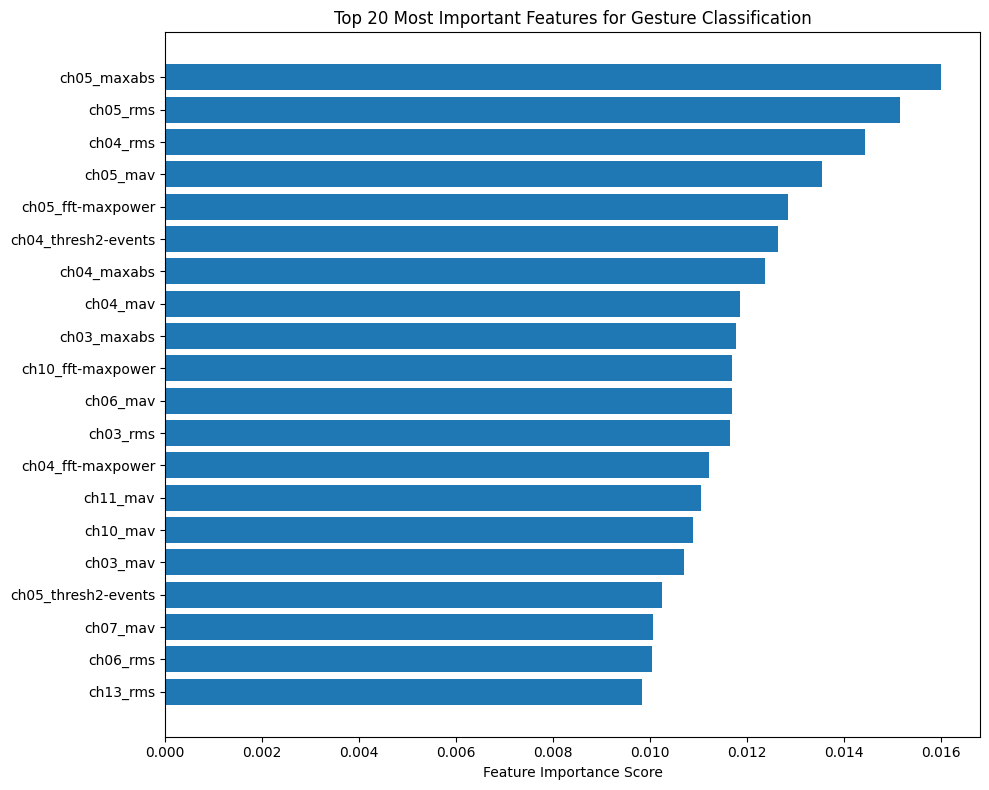

In [9]:
# Plot top 20 features
top_20 = feature_importance_df.head(20)

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_20)), top_20['importance'])
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Feature Importance Score')
plt.title('Top 20 Most Important Features for Gesture Classification')
plt.gca().invert_yaxis()  # Most important at top
plt.tight_layout()
plt.show()

## Analyze by channels

> It seems as though we have a few more important channels than others.  We may want to highlight which contacts/electrodes have information and highlight that as a conclusion of our analysis (possibly for a redesign) —BM

### Ranking

In [10]:
# Calculate total importance for each channel
# Tells us which physical electrodes give us the most useful signal

# Dictionary to store channel importance
channel_importance = {}

# Go through every feature and add up importance by channel
for i, row in feature_importance_df.iterrows():
    feature_name = row['feature']
    importance_score = row['importance']
    
    # Extract channel number from feature name
    if 'ch' in feature_name:
        # Find the channel number part
        start_index = feature_name.find('ch') + 2
        channel_num = ''
        
        # Read numbers after 'ch'
        for char in feature_name[start_index:]:
            if char.isdigit():
                channel_num += char
            else:
                break
        
        if channel_num:
            channel_name = f"ch{channel_num}"
            
            # Add this feature's importance to channel total
            if channel_name in channel_importance:
                channel_importance[channel_name] += importance_score
            else:
                channel_importance[channel_name] = importance_score

# Get all channel names and sort them two ways:
# 1. By channel number
# 2. By importance (highest to lowest)

# make sure we have all channels from ch00 to ch15
all_channels = [f"ch{str(i).zfill(2)}" for i in range(16)] 

# Sort by channel number
channels_by_number = sorted(channel_importance.keys())
importance_by_number = [channel_importance[ch] for ch in channels_by_number]

# Sort by importance (highest to lowest)
channels_by_importance = sorted(channel_importance.keys(), key=lambda x: channel_importance[x], reverse=True)
importance_by_importance = [channel_importance[ch] for ch in channels_by_importance]

print("Channels ranked by importance value:")
for i, channel in enumerate(channels_by_importance, 1):
    print(f"  {i:2}. {channel}: {channel_importance[channel]:.6f}")

Channels ranked by importance value:
   1. ch05: 0.091564
   2. ch04: 0.087679
   3. ch06: 0.070368
   4. ch03: 0.069165
   5. ch10: 0.064929
   6. ch11: 0.060399
   7. ch07: 0.060160
   8. ch13: 0.058931
   9. ch09: 0.058621
  10. ch14: 0.057779
  11. ch01: 0.055022
  12. ch15: 0.054637
  13. ch08: 0.054122
  14. ch02: 0.053475
  15. ch12: 0.051885
  16. ch00: 0.051262


### Plots

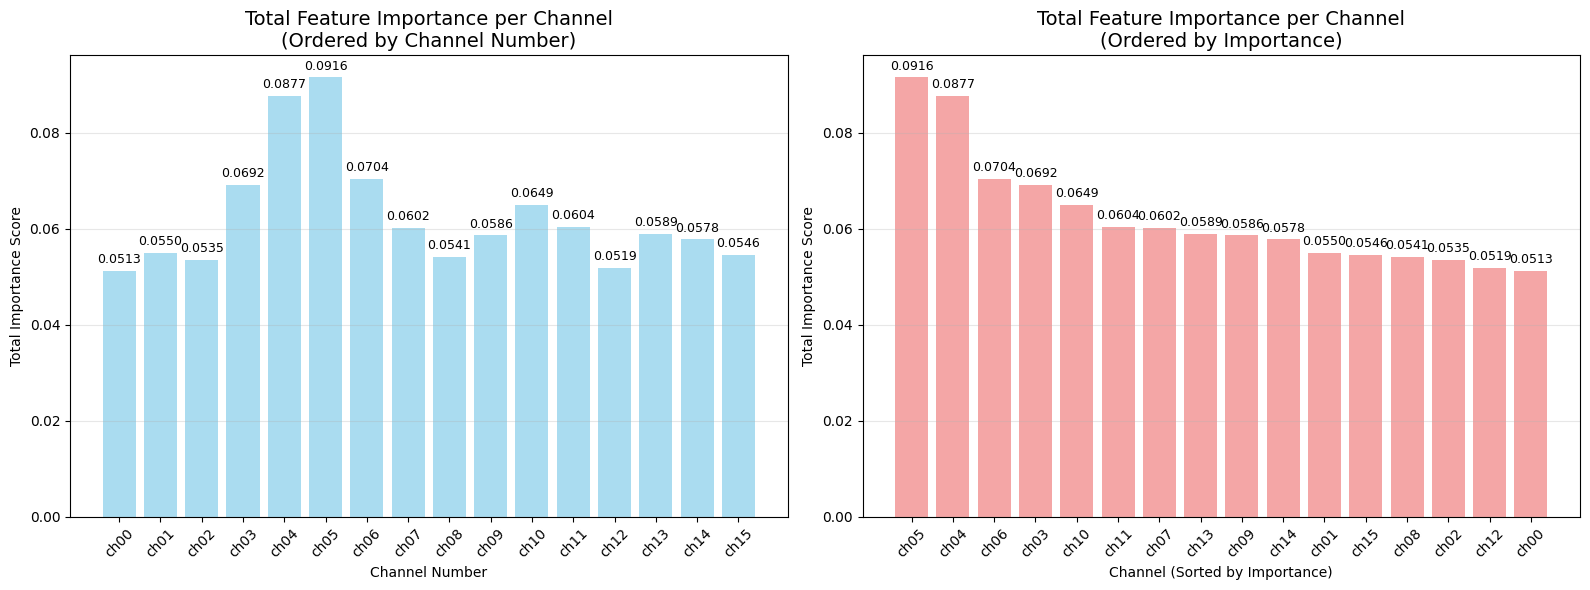

In [11]:
# Create two plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# LEFT PLOT: Ordered by channel number
bars1 = ax1.bar(channels_by_number, importance_by_number, color='skyblue', alpha=0.7)
ax1.set_title('Total Feature Importance per Channel\n(Ordered by Channel Number)', fontsize=14)
ax1.set_xlabel('Channel Number')
ax1.set_ylabel('Total Importance Score')
ax1.tick_params(axis='x', rotation=45)

# Add numbers on top of bars
for bar, imp in zip(bars1, importance_by_number):
    if imp > 0:  # Only label bars with non-zero importance
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{imp:.4f}', ha='center', va='bottom', fontsize=9)

# Add grid for easier reading
ax1.grid(True, alpha=0.3, axis='y')

# RIGHT PLOT: Ordered by importance (highest to lowest)
bars2 = ax2.bar(channels_by_importance, importance_by_importance, color='lightcoral', alpha=0.7)
ax2.set_title('Total Feature Importance per Channel\n(Ordered by Importance)', fontsize=14)
ax2.set_xlabel('Channel (Sorted by Importance)')
ax2.set_ylabel('Total Importance Score')
ax2.tick_params(axis='x', rotation=45)

# Add numbers on top of bars
for bar, imp in zip(bars2, importance_by_importance):
    if imp > 0:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{imp:.4f}', ha='center', va='bottom', fontsize=9)

ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [12]:
# Some insights for redesign
# Calculate what percentage of total importance comes from top channels
total_all_importance = sum(importance_by_importance)
top_5_total = sum([channel_importance[ch] for ch in channels_by_importance[:5]])
print(f"Top 5 channels account for {top_5_total:.4f} ({top_5_total/total_all_importance:.1%}) of total importance:")
print(f"- Highest priority: Channels {', '.join(channels_by_importance[:5])} may be the most important for gesture recognition")
print(f"\nChannels {', '.join(channels_by_importance[-3:])} contribute the least")

Top 5 channels account for 0.3837 (38.4%) of total importance:
- Highest priority: Channels ch05, ch04, ch06, ch03, ch10 may be the most important for gesture recognition

Channels ch02, ch12, ch00 contribute the least


## Dimensionality reduction

> we may want to develop some plots exploring dimension reduction and how our important features (and individuals) map to that space. PCA, t-SNE are both easy to implement using SciKit learn —BM

### PCA

In [13]:
from sklearn.decomposition import PCA

# use correlation between features to see which ones are similar
feature_correlation_matrix = df_no_outliers[feature_cols].corr()
print(f"Correlation matrix shape: {feature_correlation_matrix.shape}")

# PCA on feature correlation matrix
pca_features = PCA(n_components=2)
feature_pca_results = pca_features.fit_transform(feature_correlation_matrix)

print(f"PCA explained variance: {pca_features.explained_variance_ratio_}")

Correlation matrix shape: (160, 160)
PCA explained variance: [0.6671338  0.11327027]


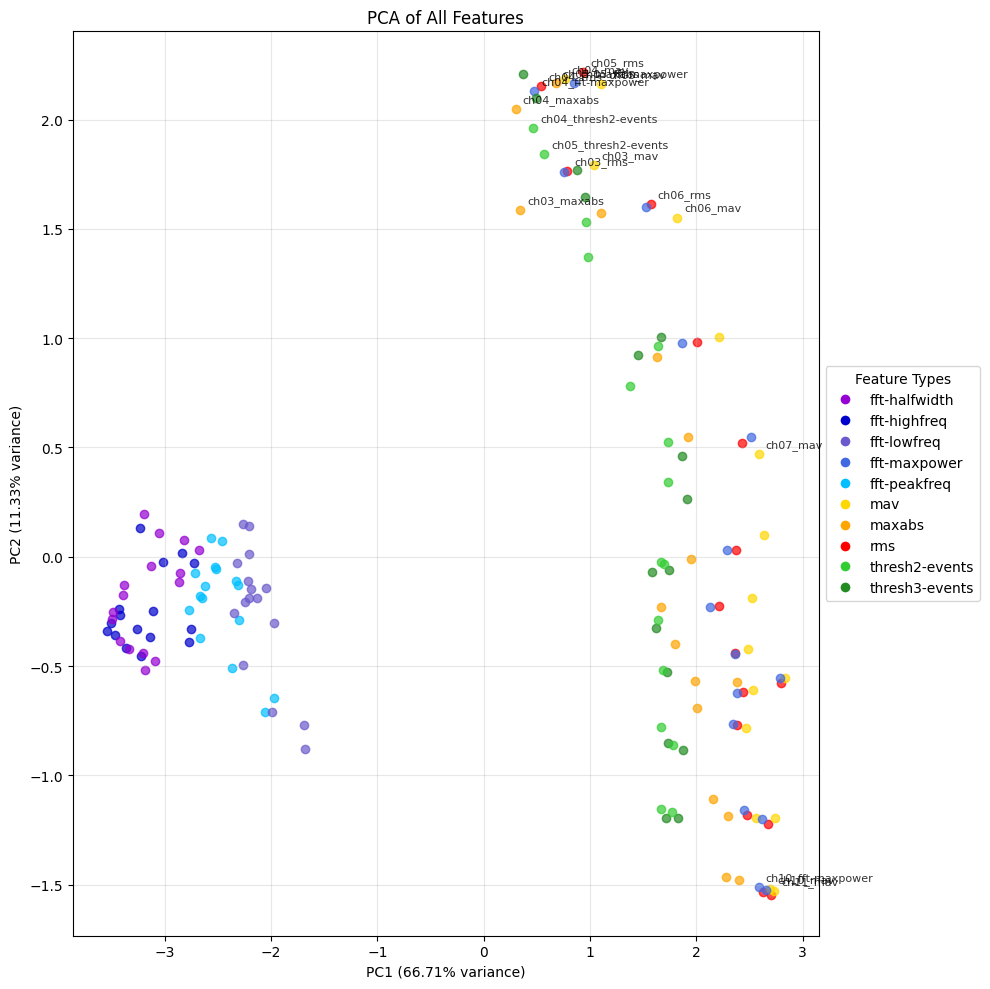

In [14]:
# Use same color scheme as t-SNE for consistency
feature_color_map = {
    'fft-halfwidth': 'darkviolet',
    'fft-highfreq': 'mediumblue',
    'fft-lowfreq': 'slateblue',
    'fft-maxpower': 'royalblue',
    'fft-peakfreq': 'deepskyblue',
    'mav': 'gold',
    'maxabs': 'orange',
    'rms': 'red',
    'thresh2-events': 'limegreen',
    'thresh3-events': 'forestgreen'
}

# Prepare feature colors and types
feature_colors = []
feature_types = []

for i, feature in enumerate(feature_cols):
    # Extract exact feature type (everything after "chXX_")
    feature_type = feature.split('_', 1)[1]
    feature_types.append(feature_type)
    feature_colors.append(feature_color_map[feature_type])

# Create PCA plot
plt.figure(figsize=(10,10))

# Plot each feature as a point
for i, feature in enumerate(feature_cols):
    plt.scatter(feature_pca_results[i, 0], feature_pca_results[i, 1], 
               c=feature_colors[i], alpha=0.7)
    
    # Only label most important features to avoid clutter
    importance = feature_importance_df[feature_importance_df['feature'] == feature]['importance'].values[0]
    if importance > 0.01:
        plt.annotate(feature, (feature_pca_results[i, 0], feature_pca_results[i, 1]),
                    xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

plt.xlabel(f'PC1 ({pca_features.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca_features.explained_variance_ratio_[1]:.2%} variance)')
plt.title('PCA of All Features')
plt.grid(True, alpha=0.3)

# Create legend in alphabetical order
from matplotlib.lines import Line2D
legend_elements = []

# Sort feature types alphabetically for legend
sorted_feature_types = sorted(feature_color_map.keys())

for feature_type in sorted_feature_types:
    legend_elements.append(Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor=feature_color_map[feature_type], 
                                markersize=8, label=feature_type))

plt.legend(handles=legend_elements, title='Feature Types', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

### t-SNE ⏳

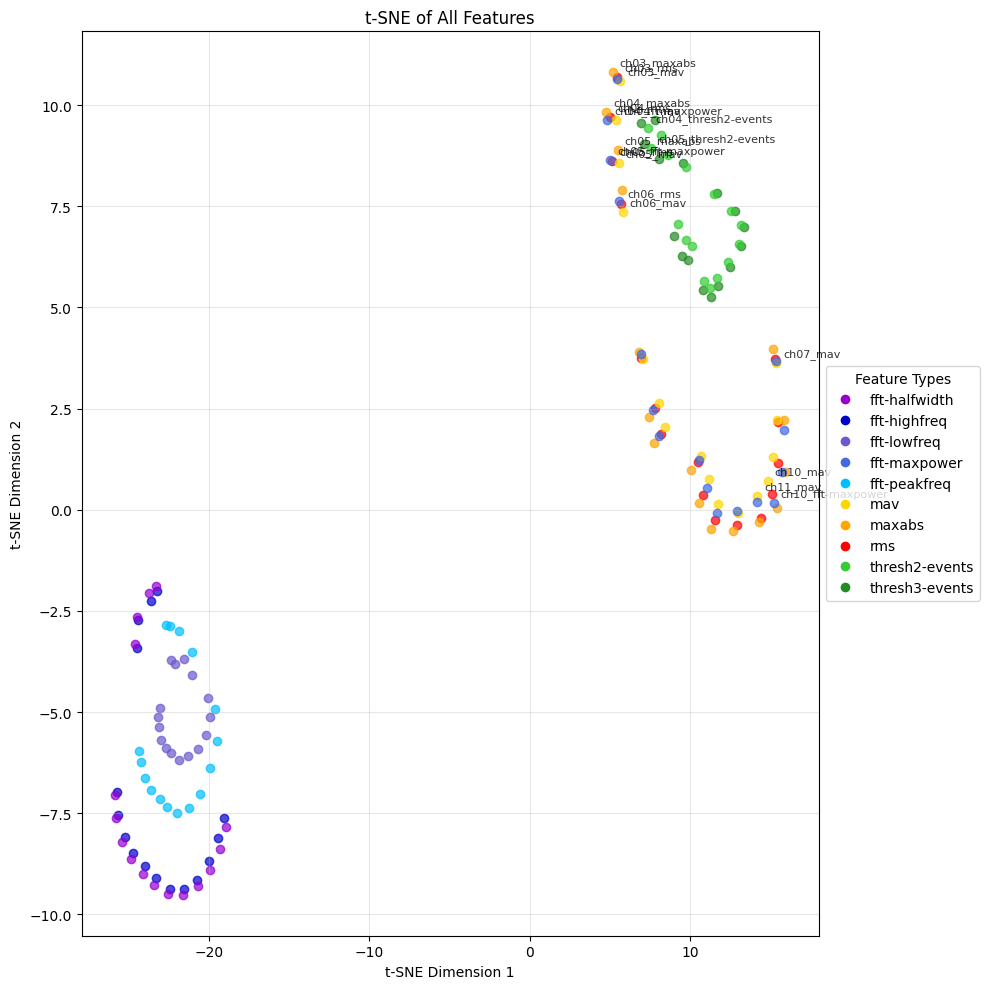

In [15]:
# NOTE: May take some time to run!

# Basic features: distinct colors (same as PCA)
# feature_color_map = {
#     'fft-halfwidth': 'darkviolet',
#     'fft-highfreq': 'mediumblue',
#     'fft-lowfreq': 'slateblue',
#     'fft-maxpower': 'royalblue',
#     'fft-peakfreq': 'deepskyblue',
#     'mav': 'gold',
#     'maxabs': 'orange',
#     'rms': 'red',
#     'thresh2-events': 'limegreen',
#     'thresh3-events': 'forestgreen'
# }

# Prepare feature colors and types
feature_colors = []
feature_types = []

for i, feature in enumerate(feature_cols):
    # Extract feature type (everything after "chXX_")
    feature_type = feature.split('_', 1)[1]
    feature_types.append(feature_type)
    feature_colors.append(feature_color_map[feature_type])

from sklearn.manifold import TSNE
import os

# File to save t-SNE results
tsne_results_file = "../data/processed/tsne_feature_results.npy"

# Check if we already have t-SNE results saved
if os.path.exists(tsne_results_file):
    feature_tsne_results = np.load(tsne_results_file)
    
else:    
    # Calculate feature correlations
    feature_correlation_matrix = df_no_outliers[feature_cols].corr()
    
    # Run t-SNE
    tsne_features = TSNE(n_components=2, random_state=13, perplexity=30)
    feature_tsne_results = tsne_features.fit_transform(feature_correlation_matrix)
    
    # Save results
    np.save(tsne_results_file, feature_tsne_results)

# Create t-SNE plot
plt.figure(figsize=(10, 10))

# Plot each feature as a point
for i, feature in enumerate(feature_cols):
    plt.scatter(feature_tsne_results[i, 0], feature_tsne_results[i, 1], 
               c=feature_colors[i], alpha=0.7)
    
    # Only label most important features to avoid clutter
    importance = feature_importance_df[feature_importance_df['feature'] == feature]['importance'].values[0]
    if importance > 0.01:  # Only label features with importance > 0.01
        plt.annotate(feature, (feature_tsne_results[i, 0], feature_tsne_results[i, 1]),
                    xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE of All Features')
plt.grid(True, alpha=0.3)

# Create legend for all 10 feature types
from matplotlib.lines import Line2D
legend_elements = []

# Sort feature types alphabetically for legend
sorted_feature_types = sorted(feature_color_map.keys())

for feature_type in sorted_feature_types:
    legend_elements.append(Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor=feature_color_map[feature_type], 
                                markersize=8, label=feature_type))

plt.legend(handles=legend_elements, title='Feature Types', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

### Comparison

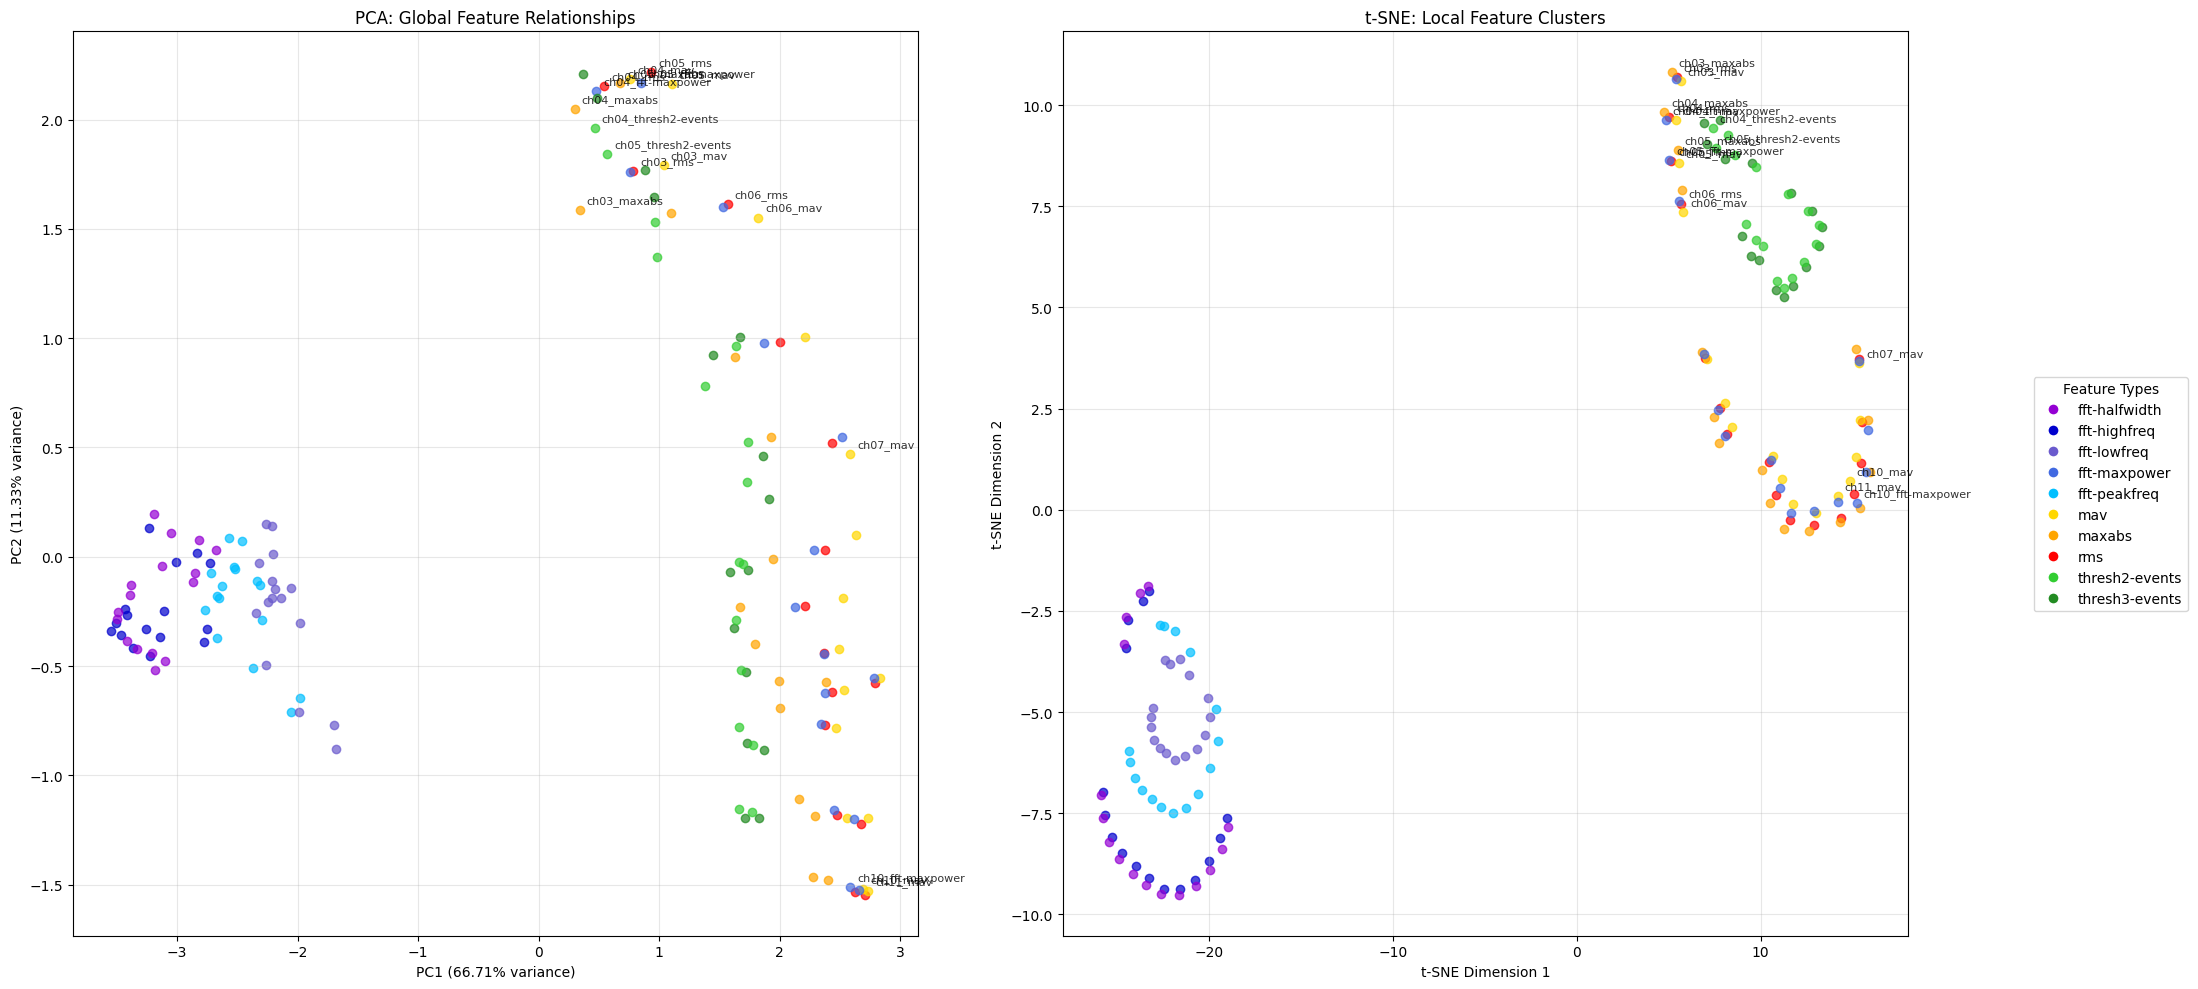

In [16]:
# COMPARING PCA AND t-SNE SIDE BY SIDE

# Create big figure with 2 plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# LEFT PLOT: PCA

# Plot each feature in PCA space
for i, feature in enumerate(feature_cols):
    ax1.scatter(feature_pca_results[i, 0], feature_pca_results[i, 1], 
                c=feature_colors[i], alpha=0.7)
    
    # Label important features (same as before)
    importance = feature_importance_df[feature_importance_df['feature'] == feature]['importance'].values[0]
    if importance > 0.01:
        ax1.annotate(feature, (feature_pca_results[i, 0], feature_pca_results[i, 1]),
                     xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

# Add labels and title for PCA plot
ax1.set_xlabel(f'PC1 ({pca_features.explained_variance_ratio_[0]:.2%} variance)')
ax1.set_ylabel(f'PC2 ({pca_features.explained_variance_ratio_[1]:.2%} variance)')
ax1.set_title('PCA: Global Feature Relationships')
ax1.grid(True, alpha=0.3)

# RIGHT PLOT: t-SNE

# Plot each feature in t-SNE space
for i, feature in enumerate(feature_cols):
    ax2.scatter(feature_tsne_results[i, 0], feature_tsne_results[i, 1], 
                c=feature_colors[i], alpha=0.7)
    
    # Label important features (same as before)
    importance = feature_importance_df[feature_importance_df['feature'] == feature]['importance'].values[0]
    if importance > 0.01:
        ax2.annotate(feature, (feature_tsne_results[i, 0], feature_tsne_results[i, 1]),
                     xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)

# Add labels and title for t-SNE plot
ax2.set_xlabel('t-SNE Dimension 1')
ax2.set_ylabel('t-SNE Dimension 2')
ax2.set_title('t-SNE: Local Feature Clusters')
ax2.grid(True, alpha=0.3)

# ADD LEGEND

# Create legend in alphabetical order 
from matplotlib.lines import Line2D
legend_elements = []

# Sort feature types alphabetically
sorted_feature_types = sorted(feature_color_map.keys())

for feature_type in sorted_feature_types:
    legend_elements.append(Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=feature_color_map[feature_type], 
                                 markersize=8, label=feature_type))

# Add legend to figure (not to a specific axis)
fig.legend(handles=legend_elements, title='Feature Types', 
           loc='center right', bbox_to_anchor=(1.1, 0.5))

# Make everything fit nicely
plt.tight_layout()
plt.show()

## Correlation analysis of top features

In [17]:
# Check for highly correlated features among top features

# Look at top 50 features
top_50_features = feature_importance_df.head(50)['feature'].tolist()

# Calculate correlations between top features
correlation_matrix = df_no_outliers[top_50_features].corr()

# Find features that are very similar (correlation > 0.8)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = abs(correlation_matrix.iloc[i, j])
        if corr_value > 0.8:
            feat1 = correlation_matrix.columns[i]
            feat2 = correlation_matrix.columns[j]
            high_corr_pairs.append((feat1, feat2, corr_value))

print(f"Found: {len(high_corr_pairs)} highly correlated feature pairs (r > 0.8)")

if high_corr_pairs:
    print("Some highly correlated features:")
    for feat1, feat2, corr in high_corr_pairs[:5]:
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")

Found: 113 highly correlated feature pairs (r > 0.8)
Some highly correlated features:
  ch05_maxabs <-> ch05_rms: 0.960
  ch05_maxabs <-> ch05_mav: 0.912
  ch05_maxabs <-> ch05_fft-maxpower: 0.880
  ch05_rms <-> ch05_mav: 0.984
  ch05_rms <-> ch05_fft-maxpower: 0.938


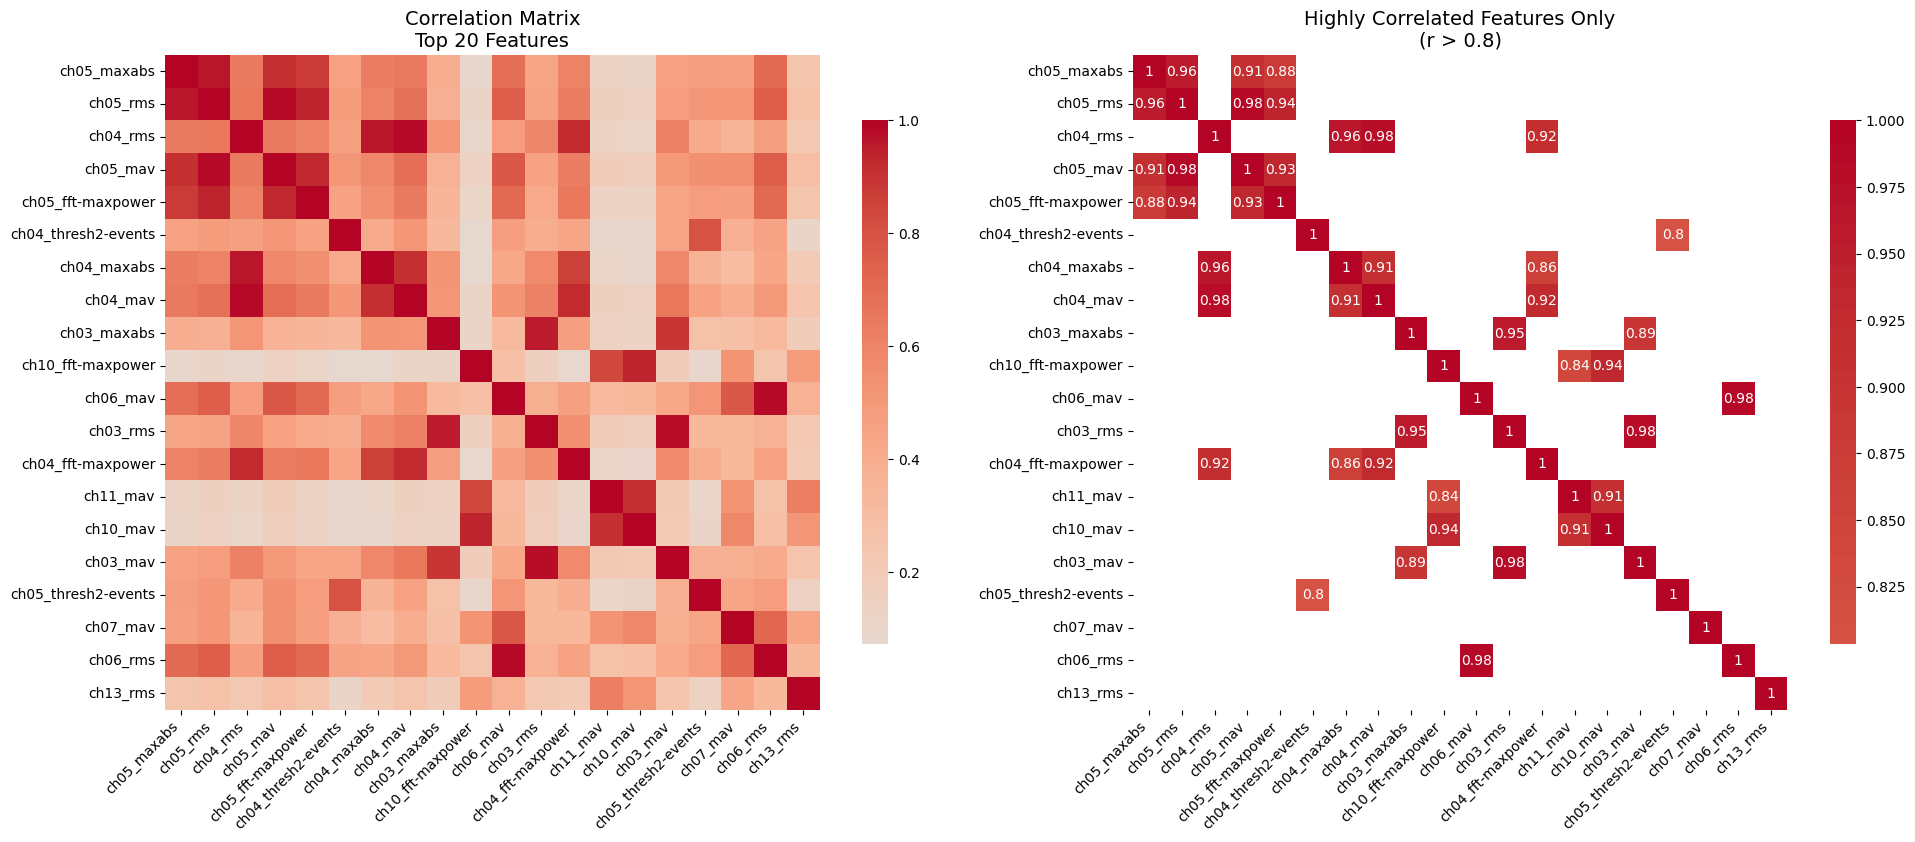

In [18]:
# Visualize correlation matrix of top features - SIDE BY SIDE

# Use top 20 features for the correlation matrix (easier to read)
top_20_for_corr = feature_importance_df.head(20)['feature'].tolist()

# Calculate correlation matrix for top 20 features
corr_matrix_top20 = df_no_outliers[top_20_for_corr].corr()

# Create figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Left plot: Full correlation matrix
sns.heatmap(corr_matrix_top20, 
            cmap='coolwarm', 
            center=0,
            annot=False,  # No numbers for cleaner look
            square=True,
            cbar_kws={'shrink': 0.8},
            ax=ax1)
ax1.set_title('Correlation Matrix\nTop 20 Features', fontsize=14)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

# Right plot: Only highly correlated pairs
high_corr_matrix = corr_matrix_top20.where(np.abs(corr_matrix_top20) > 0.8)

sns.heatmap(high_corr_matrix, 
            cmap='coolwarm', 
            center=0,
            annot=True,  # Show numbers for high correlations
            square=True,
            cbar_kws={'shrink': 0.8},
            mask=high_corr_matrix.isnull(),  # Hide non-correlated cells
            ax=ax2)
ax2.set_title('Highly Correlated Features Only\n(r > 0.8)', fontsize=14)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

In [19]:
# Print some statistics for top features
print(f"Total feature pairs: {len(corr_matrix_top20.columns) * (len(corr_matrix_top20.columns) - 1) // 2}")
print(f"Highly correlated pairs (r > 0.8): {len(high_corr_pairs)}")
print(f"Very highly correlated pairs (r > 0.9): {len([pair for pair in high_corr_pairs if pair[2] > 0.9])}")

Total feature pairs: 190
Highly correlated pairs (r > 0.8): 113
Very highly correlated pairs (r > 0.9): 61


## Remove redundant features

In [20]:
# Create final feature set by removing duplicates

# Start with top features
top_features = feature_importance_df.head(50)['feature'].tolist()
final_features = []

# Keep only one from each highly correlated pair
for feature in top_features:
    keep_feature = True
    
    # Check if this feature is very similar to any we already kept
    for kept_feature in final_features:
        if feature in correlation_matrix.columns and kept_feature in correlation_matrix.columns:
            corr_value = abs(correlation_matrix.loc[feature, kept_feature])
            if corr_value > 0.8:
                # They're very similar - check which is more important
                imp_current = feature_importance_df[feature_importance_df['feature'] == feature]['importance'].values[0]
                imp_kept = feature_importance_df[feature_importance_df['feature'] == kept_feature]['importance'].values[0]
                
                if imp_current > imp_kept:
                    # Current feature is better, replace the old one
                    final_features.remove(kept_feature)
                    final_features.append(feature)
                    print(f"  Replaced {kept_feature} with {feature} (better importance)")
                keep_feature = False
                break
    
    if keep_feature and feature not in final_features:
        final_features.append(feature)

print(f"{len(final_features)} features after removing duplicates")

# Show what types of features we kept
print("Types of features in final set:")
feature_types = {}
for feature in final_features:
    if 'rms' in feature.lower():
        feature_types['RMS'] = feature_types.get('RMS', 0) + 1
    elif 'fft' in feature.lower():
        feature_types['FFT'] = feature_types.get('FFT', 0) + 1  
    elif 'max' in feature.lower():
        feature_types['Max'] = feature_types.get('Max', 0) + 1
    else:
        feature_types['Other'] = feature_types.get('Other', 0) + 1

for ftype, count in feature_types.items():
    print(f"  {ftype}: {count} features")

14 features after removing duplicates
Types of features in final set:
  Max: 5 features
  RMS: 3 features
  Other: 4 features
  FFT: 2 features


## Visualization of final feature set

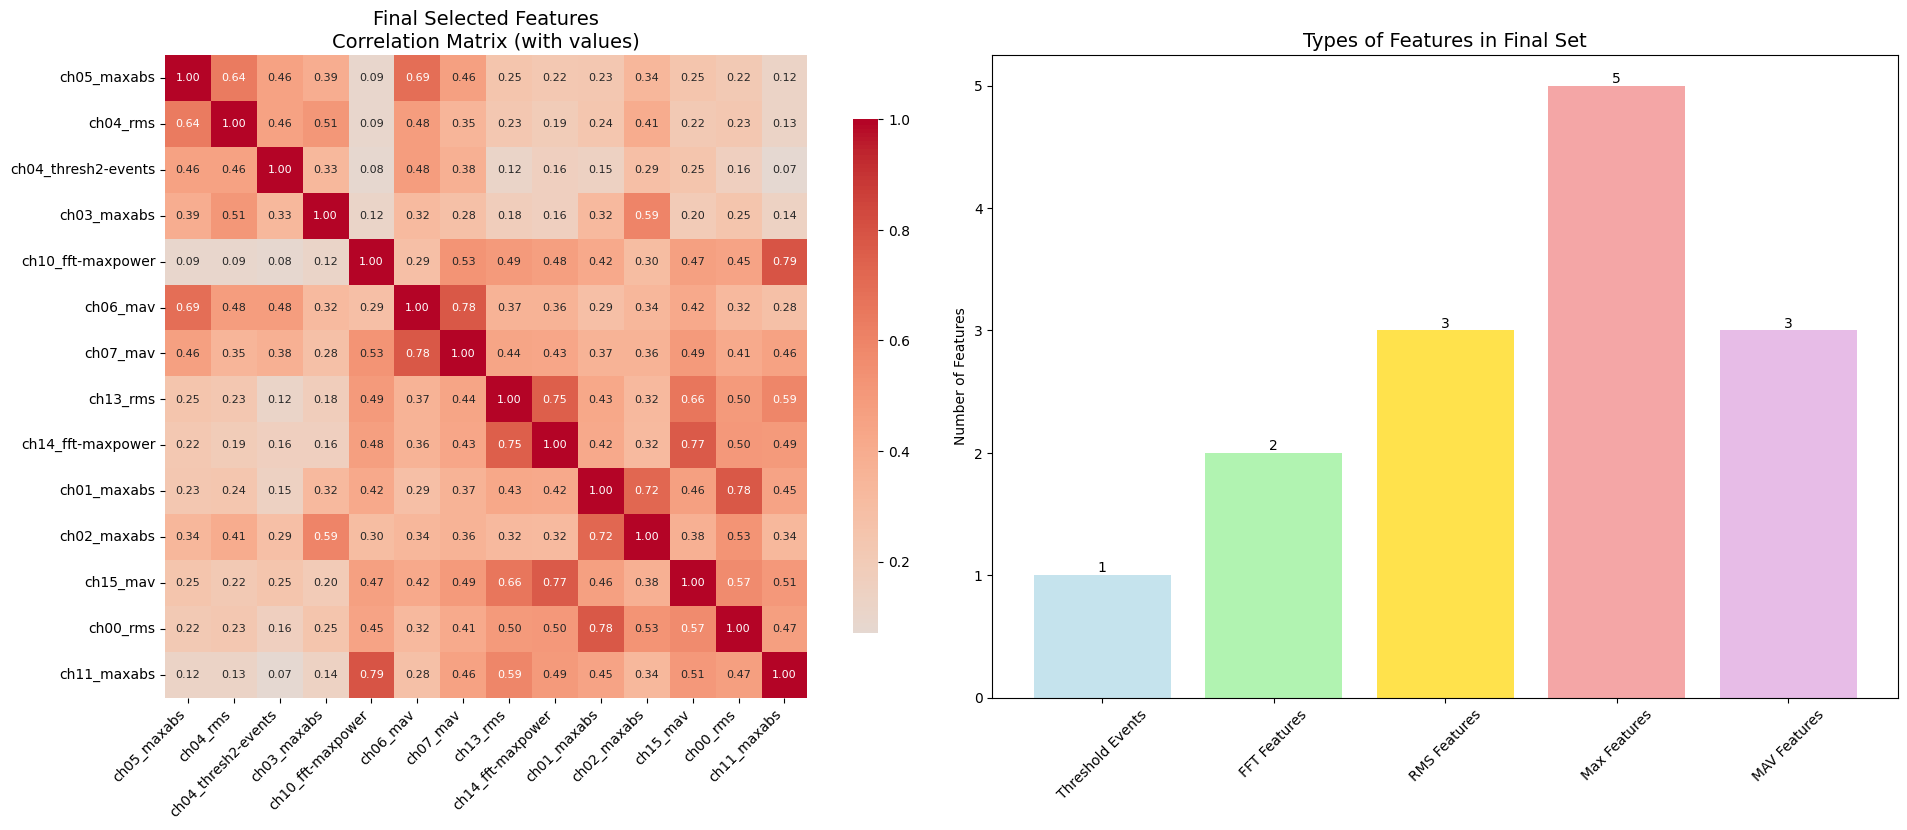

In [21]:
# Simple visualization of final feature selection results

# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Correlation matrix of final selected features WITH NUMBERS

# Calculate correlation for our final features
final_corr_matrix = df_no_outliers[final_features].corr()

# Create the heatmap with correlation values
sns.heatmap(final_corr_matrix, 
            cmap='coolwarm', 
            center=0,
            annot=True,  # CHANGED: Now shows the correlation numbers
            square=True,
            cbar_kws={'shrink': 0.8},
            ax=ax1,
            fmt='.2f',  # Show 2 decimal places for the numbers
            annot_kws={'size': 8})  # Make the numbers a bit smaller

ax1.set_title('Final Selected Features\nCorrelation Matrix (with values)', fontsize=14)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

# Plot 2: Feature types breakdown with actual names

# Count feature types with better names
feature_type_counts = {
    'Threshold Events': 0,
    'FFT Features': 0, 
    'RMS Features': 0,
    'Max Features': 0,
    'MAV Features': 0
}

for feature in final_features:
    if 'thresh' in feature.lower():
        feature_type_counts['Threshold Events'] += 1
    elif 'fft' in feature.lower():
        feature_type_counts['FFT Features'] += 1
    elif 'rms' in feature.lower():
        feature_type_counts['RMS Features'] += 1
    elif 'max' in feature.lower():
        feature_type_counts['Max Features'] += 1
    elif 'mav' in feature.lower():
        feature_type_counts['MAV Features'] += 1

# Remove types with zero count
feature_type_counts = {k: v for k, v in feature_type_counts.items() if v > 0}

# Create bar chart
types = list(feature_type_counts.keys())
counts = list(feature_type_counts.values())
colors = ['lightblue', 'lightgreen', 'gold', 'lightcoral', 'plum']

bars = ax2.bar(types, counts, color=colors[:len(types)], alpha=0.7)
ax2.set_title('Types of Features in Final Set', fontsize=14)
ax2.set_ylabel('Number of Features')
ax2.tick_params(axis='x', rotation=45)

# Add numbers on top of bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [22]:
# Simple summary
print(f"Final Feature Selection:")
print(f"- Started with: 160 total features")
print(f"- Selected: {len(final_features)} features")
print(f"- Feature types selected:")
for feature_type, count in feature_type_counts.items():
    print(f"  - {feature_type}: {count}")

Final Feature Selection:
- Started with: 160 total features
- Selected: 14 features
- Feature types selected:
  - Threshold Events: 1
  - FFT Features: 2
  - RMS Features: 3
  - Max Features: 5
  - MAV Features: 3


## Save final dataset and feature importance

In [23]:
# Create final dataset with selected features

# Keep only metadata and our selected features
columns_to_keep = ['user', 'gesture'] + final_features
final_df = df_no_outliers[columns_to_keep].copy()

print(f"Final dataset shape: {final_df.shape}")
print(f"Columns in final dataset: {list(final_df.columns)}")

# Save to file
output_file = "../data/processed/features_for_personalization.csv"
final_df.to_csv(output_file, index=False)
print(f"Saved to: {output_file}")

Final dataset shape: (135299, 16)
Columns in final dataset: ['user', 'gesture', 'ch05_maxabs', 'ch04_rms', 'ch04_thresh2-events', 'ch03_maxabs', 'ch10_fft-maxpower', 'ch06_mav', 'ch07_mav', 'ch13_rms', 'ch14_fft-maxpower', 'ch01_maxabs', 'ch02_maxabs', 'ch15_mav', 'ch00_rms', 'ch11_maxabs']
Saved to: ../data/processed/features_for_personalization.csv


In [24]:
# Also save feature importance for reference
importance_file = "../data/processed/feature_importance_ranking.csv"
feature_importance_df.to_csv(importance_file, index=False)
print(f"Feature importance saved to: {importance_file}")

Feature importance saved to: ../data/processed/feature_importance_ranking.csv


### Save test data

In [25]:
# Save test data for future model evaluation
# This data was NEVER used in feature selection

test_output_path = "../data/processed/test_data_holdout.csv"
df_test.to_csv(test_output_path, index=False)
print(f"Saved test holdout data to: {test_output_path}")
print("This test data was NEVER used in feature selection - perfect for final model evaluation!")

# Also save the training data with transformations if needed
train_output_path = "../data/processed/training_data_transformed.csv"
df_train.to_csv(train_output_path, index=False)
print(f"Saved training data to: {train_output_path}")

Saved test holdout data to: ../data/processed/test_data_holdout.csv
This test data was NEVER used in feature selection - perfect for final model evaluation!
Saved training data to: ../data/processed/training_data_transformed.csv


## Log results in a table

Logs results in a table (results/feature_selection.csv) (as per [02_EDA_feature_selection_and_engineering](https://docs.google.com/document/d/1Kl0Oz5YV63c0b6lbUHhTlcTJ7h4KpRAAGrQZfKX6Zyw/edit?usp=sharing)).

Create a log (table) that explains why each of the 160 features was either KEPT or DROPPED. This log needs to be saved as results/feature_selection.csv, as required by the project checklist.

In [26]:
# Prepare all necessary data structures

# Get list of ALL original features (160 columns)
all_original_features = feature_cols # 'feature_cols' defined earlier in the notebook

# The list of features we decided to KEEP (final feature set calculated above)
features_to_keep_set = set(final_features)

# List of top 50 features considered before redundancy check
top_50_features_list = feature_importance_df.head(50)['feature'].tolist()
top_50_set = set(top_50_features_list)
# top_50_set

In [27]:
# Make list to store feature decisions
feature_choices = []

# Go through every single feature one at a time
for current_feature in all_original_features:
    
    # Try to find this feature in our importance results, search for feature name
    found_row = feature_importance_df[feature_importance_df['feature'] == current_feature]
    
    # Get importance score number
    # .iloc[0] gets first matching row, then take 'importance' value
    score = found_row['importance'].iloc[0]
    
    # Figure out if we should keep or drop this feature
    
    # First check: is it in final chosen features?
    if current_feature in final_features:
        what_happened = 'keep'
    
    # Second check: is it even in top 50 important features?
    elif current_feature not in top_50_features_list:
        # Find where this feature ranks
        rank_position = feature_importance_df[feature_importance_df['feature'] == current_feature].index[0] + 1
        what_happened = 'drop'
    
    # If we get here, it was in top 50 but we still dropped it...
    else:
        what_happened = 'drop'
    
    # Add all info about this feature to list
    feature_choices.append({
        'Feature': current_feature,  # feature name
        'Importance Score': score,   # How important Random Forest said it was
        'Top 50': 1 if current_feature in top_50_features_list else 0,  # 1 for yes, 0 for no
        'Final Set': 1 if current_feature in final_features else 0,     # 1 for yes, 0 for no
        'Decision': what_happened    # Keep or Drop
    })

# Turn list into table
feature_log_table = pd.DataFrame(feature_choices)

# Preview
# print(feature_log_table.head(10))
feature_log_table

,Feature,Importance Score,Top 50,Final Set,Decision
0,ch00_rms,0.008094,1,1,keep
1,ch01_rms,0.008772,1,0,drop
2,ch02_rms,0.008083,1,0,drop
3,ch03_rms,0.011648,1,0,drop
4,ch04_rms,0.014433,1,1,keep
...,...,...,...,...,...
155,ch11_thresh2-events,0.005444,0,0,drop
156,ch12_thresh2-events,0.004917,0,0,drop
157,ch13_thresh2-events,0.005042,0,0,drop
158,ch14_thresh2-events,0.005370,0,0,drop


In [28]:
# Show which features we keep
print(f"Keep {len(final_features)} features out of {len(all_original_features)} total:")
for i, feature_name in enumerate(final_features, 1):
    print(feature_name)

Keep 14 features out of 160 total:
ch05_maxabs
ch04_rms
ch04_thresh2-events
ch03_maxabs
ch10_fft-maxpower
ch06_mav
ch07_mav
ch13_rms
ch14_fft-maxpower
ch01_maxabs
ch02_maxabs
ch15_mav
ch00_rms
ch11_maxabs


### Save feature_selection.csv

In [29]:
# Save table to CSV as required
save_path = "../results/feature_selection.csv"
feature_log_table.to_csv(save_path, index=False)

# Verify
print(f"Saved feature decisions to: {save_path}")

Saved feature decisions to: ../results/feature_selection.csv
